In [5]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [103]:
num_epochs = 500
batch_size = 1
learning_rate = 0.001

input_size = 222
sequence_length = 4
hidden_size = 128
num_layers = 2

In [73]:
initialize=True

In [74]:
df = pd.read_csv('../data/united_data.csv', index_col=0).fillna(0)
y = df['Corn_Yield']
X = df.drop(columns=['Corn_Yield'], axis=1)

In [127]:
y

2016-Nicollet County    209.4
2020-Nicollet County    205.9
2021-Nicollet County    209.5
2006-Nicollet County    180.0
2007-Nicollet County    145.0
                        ...  
2011-Rice County        158.3
2012-Rice County        186.1
2013-Rice County        168.5
2014-Rice County        157.1
2015-Rice County        201.1
Name: Corn_Yield, Length: 1172, dtype: float64

In [138]:
def transform(row):
    print(row.index)
    return row


In [139]:
y['year'] = y.index

In [143]:
y.apply(transform)

Index(['2016-Nicollet County', '2020-Nicollet County', '2021-Nicollet County',
       '2006-Nicollet County', '2007-Nicollet County', '2008-Nicollet County',
       '2009-Nicollet County', '2010-Nicollet County', '2011-Nicollet County',
       '2012-Nicollet County',
       ...
       '2007-Rice County', '2008-Rice County', '2009-Rice County',
       '2010-Rice County', '2011-Rice County', '2012-Rice County',
       '2013-Rice County', '2014-Rice County', '2015-Rice County', 'year'],
      dtype='object', length=1173)
Index(['2016-Nicollet County', '2020-Nicollet County', '2021-Nicollet County',
       '2006-Nicollet County', '2007-Nicollet County', '2008-Nicollet County',
       '2009-Nicollet County', '2010-Nicollet County', '2011-Nicollet County',
       '2012-Nicollet County',
       ...
       '2007-Rice County', '2008-Rice County', '2009-Rice County',
       '2010-Rice County', '2011-Rice County', '2012-Rice County',
       '2013-Rice County', '2014-Rice County', '2015-Rice Count

,Corn_Yield,year
2016-Nicollet County,209.4,2016-Nicollet County
2020-Nicollet County,205.9,2020-Nicollet County
2021-Nicollet County,209.5,2021-Nicollet County
2006-Nicollet County,180.0,2006-Nicollet County
2007-Nicollet County,145.0,2007-Nicollet County
...,...,...
2012-Rice County,186.1,2012-Rice County
2013-Rice County,168.5,2013-Rice County
2014-Rice County,157.1,2014-Rice County
2015-Rice County,201.1,2015-Rice County


In [75]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [77]:
train_data=MyDataset(X_train.to_numpy(), y_train.to_numpy())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=False)

test_data=MyDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [78]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)


In [120]:
X_test.shape

torch.Size([293, 888])

In [80]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        if initialize:
            h0 = torch.zeros(num_layers, x.size(0), hidden_size)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size)
            x, _ = self.lstm(x,(h0,c0))
        else:
            x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [81]:
model = LSTM(input_size, hidden_size, num_layers)

In [104]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (weather, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        weather = weather.reshape(-1, sequence_length, input_size)
        
        # Forward pass
        outputs = model(weather)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/500], Step [100/293], Loss: 0.0291
Epoch [1/500], Step [200/293], Loss: 24.2119
Epoch [2/500], Step [100/293], Loss: 1.9307
Epoch [2/500], Step [200/293], Loss: 1.3295
Epoch [3/500], Step [100/293], Loss: 1.1579
Epoch [3/500], Step [200/293], Loss: 3.7024
Epoch [4/500], Step [100/293], Loss: 0.0111
Epoch [4/500], Step [200/293], Loss: 0.0288
Epoch [5/500], Step [100/293], Loss: 0.7806
Epoch [5/500], Step [200/293], Loss: 0.0838
Epoch [6/500], Step [100/293], Loss: 0.1617
Epoch [6/500], Step [200/293], Loss: 3.8994
Epoch [7/500], Step [100/293], Loss: 0.0063
Epoch [7/500], Step [200/293], Loss: 3.0628
Epoch [8/500], Step [100/293], Loss: 0.0758
Epoch [8/500], Step [200/293], Loss: 3.7009
Epoch [9/500], Step [100/293], Loss: 0.0008
Epoch [9/500], Step [200/293], Loss: 0.6716
Epoch [10/500], Step [100/293], Loss: 1.1207
Epoch [10/500], Step [200/293], Loss: 0.0380
Epoch [11/500], Step [100/293], Loss: 0.6297
Epoch [11/500], Step [200/293], Loss: 0.8742
Epoch [12/500], Step [100/2

Epoch [92/500], Step [200/293], Loss: 0.0191
Epoch [93/500], Step [100/293], Loss: 0.0162
Epoch [93/500], Step [200/293], Loss: 0.0942
Epoch [94/500], Step [100/293], Loss: 0.7785
Epoch [94/500], Step [200/293], Loss: 0.6021
Epoch [95/500], Step [100/293], Loss: 1.9014
Epoch [95/500], Step [200/293], Loss: 0.9814
Epoch [96/500], Step [100/293], Loss: 0.1883
Epoch [96/500], Step [200/293], Loss: 3.4252
Epoch [97/500], Step [100/293], Loss: 1.6280
Epoch [97/500], Step [200/293], Loss: 0.0049
Epoch [98/500], Step [100/293], Loss: 0.3984
Epoch [98/500], Step [200/293], Loss: 0.0109
Epoch [99/500], Step [100/293], Loss: 1.3451
Epoch [99/500], Step [200/293], Loss: 7.2193
Epoch [100/500], Step [100/293], Loss: 0.5814
Epoch [100/500], Step [200/293], Loss: 0.1233
Epoch [101/500], Step [100/293], Loss: 0.0175
Epoch [101/500], Step [200/293], Loss: 0.2870
Epoch [102/500], Step [100/293], Loss: 0.4638
Epoch [102/500], Step [200/293], Loss: 0.8157
Epoch [103/500], Step [100/293], Loss: 0.1319
Epo

Epoch [182/500], Step [100/293], Loss: 0.9553
Epoch [182/500], Step [200/293], Loss: 0.4493
Epoch [183/500], Step [100/293], Loss: 0.6799
Epoch [183/500], Step [200/293], Loss: 17.6161
Epoch [184/500], Step [100/293], Loss: 0.0210
Epoch [184/500], Step [200/293], Loss: 2.5140
Epoch [185/500], Step [100/293], Loss: 0.5702
Epoch [185/500], Step [200/293], Loss: 7.9892
Epoch [186/500], Step [100/293], Loss: 0.3354
Epoch [186/500], Step [200/293], Loss: 0.0027
Epoch [187/500], Step [100/293], Loss: 1.1329
Epoch [187/500], Step [200/293], Loss: 29.2162
Epoch [188/500], Step [100/293], Loss: 0.7117
Epoch [188/500], Step [200/293], Loss: 13.6742
Epoch [189/500], Step [100/293], Loss: 0.5787
Epoch [189/500], Step [200/293], Loss: 10.2529
Epoch [190/500], Step [100/293], Loss: 2.3296
Epoch [190/500], Step [200/293], Loss: 1.6823
Epoch [191/500], Step [100/293], Loss: 0.3803
Epoch [191/500], Step [200/293], Loss: 17.1433
Epoch [192/500], Step [100/293], Loss: 0.5560
Epoch [192/500], Step [200/29

Epoch [271/500], Step [100/293], Loss: 3.2153
Epoch [271/500], Step [200/293], Loss: 0.1187
Epoch [272/500], Step [100/293], Loss: 0.0106
Epoch [272/500], Step [200/293], Loss: 0.0894
Epoch [273/500], Step [100/293], Loss: 1.2997
Epoch [273/500], Step [200/293], Loss: 1.0655
Epoch [274/500], Step [100/293], Loss: 0.6679
Epoch [274/500], Step [200/293], Loss: 0.5092
Epoch [275/500], Step [100/293], Loss: 0.6793
Epoch [275/500], Step [200/293], Loss: 0.0930
Epoch [276/500], Step [100/293], Loss: 1.2126
Epoch [276/500], Step [200/293], Loss: 205.6874
Epoch [277/500], Step [100/293], Loss: 12.5950
Epoch [277/500], Step [200/293], Loss: 4.0945
Epoch [278/500], Step [100/293], Loss: 0.0308
Epoch [278/500], Step [200/293], Loss: 1.4240
Epoch [279/500], Step [100/293], Loss: 0.0214
Epoch [279/500], Step [200/293], Loss: 0.9980
Epoch [280/500], Step [100/293], Loss: 2.3789
Epoch [280/500], Step [200/293], Loss: 5.0739
Epoch [281/500], Step [100/293], Loss: 0.0000
Epoch [281/500], Step [200/293]

Epoch [360/500], Step [100/293], Loss: 1.0595
Epoch [360/500], Step [200/293], Loss: 0.0165
Epoch [361/500], Step [100/293], Loss: 0.5751
Epoch [361/500], Step [200/293], Loss: 7.6030
Epoch [362/500], Step [100/293], Loss: 2.3960
Epoch [362/500], Step [200/293], Loss: 15.8325
Epoch [363/500], Step [100/293], Loss: 3.6256
Epoch [363/500], Step [200/293], Loss: 0.3292
Epoch [364/500], Step [100/293], Loss: 4.9264
Epoch [364/500], Step [200/293], Loss: 0.0521
Epoch [365/500], Step [100/293], Loss: 0.0713
Epoch [365/500], Step [200/293], Loss: 0.1099
Epoch [366/500], Step [100/293], Loss: 5.0462
Epoch [366/500], Step [200/293], Loss: 6.3458
Epoch [367/500], Step [100/293], Loss: 1.3003
Epoch [367/500], Step [200/293], Loss: 1.7192
Epoch [368/500], Step [100/293], Loss: 0.2860
Epoch [368/500], Step [200/293], Loss: 0.2480
Epoch [369/500], Step [100/293], Loss: 3.3516
Epoch [369/500], Step [200/293], Loss: 0.1020
Epoch [370/500], Step [100/293], Loss: 5.1638
Epoch [370/500], Step [200/293], 

Epoch [449/500], Step [100/293], Loss: 0.3156
Epoch [449/500], Step [200/293], Loss: 0.4644
Epoch [450/500], Step [100/293], Loss: 0.0699
Epoch [450/500], Step [200/293], Loss: 2.1551
Epoch [451/500], Step [100/293], Loss: 0.0718
Epoch [451/500], Step [200/293], Loss: 0.0267
Epoch [452/500], Step [100/293], Loss: 0.3740
Epoch [452/500], Step [200/293], Loss: 1.8141
Epoch [453/500], Step [100/293], Loss: 0.7264
Epoch [453/500], Step [200/293], Loss: 1.1370
Epoch [454/500], Step [100/293], Loss: 2.6586
Epoch [454/500], Step [200/293], Loss: 1.0124
Epoch [455/500], Step [100/293], Loss: 0.0646
Epoch [455/500], Step [200/293], Loss: 0.9391
Epoch [456/500], Step [100/293], Loss: 2.1482
Epoch [456/500], Step [200/293], Loss: 3.1384
Epoch [457/500], Step [100/293], Loss: 0.2849
Epoch [457/500], Step [200/293], Loss: 2.0306
Epoch [458/500], Step [100/293], Loss: 0.1630
Epoch [458/500], Step [200/293], Loss: 15.4577
Epoch [459/500], Step [100/293], Loss: 0.1400
Epoch [459/500], Step [200/293], 

In [105]:
weather = X_test.reshape(-1, sequence_length, input_size)
labels = y_test
outputs = model(weather)
loss = criterion(outputs.reshape(-1), labels)
loss

tensor(10.0048, grad_fn=<MseLossBackward0>)

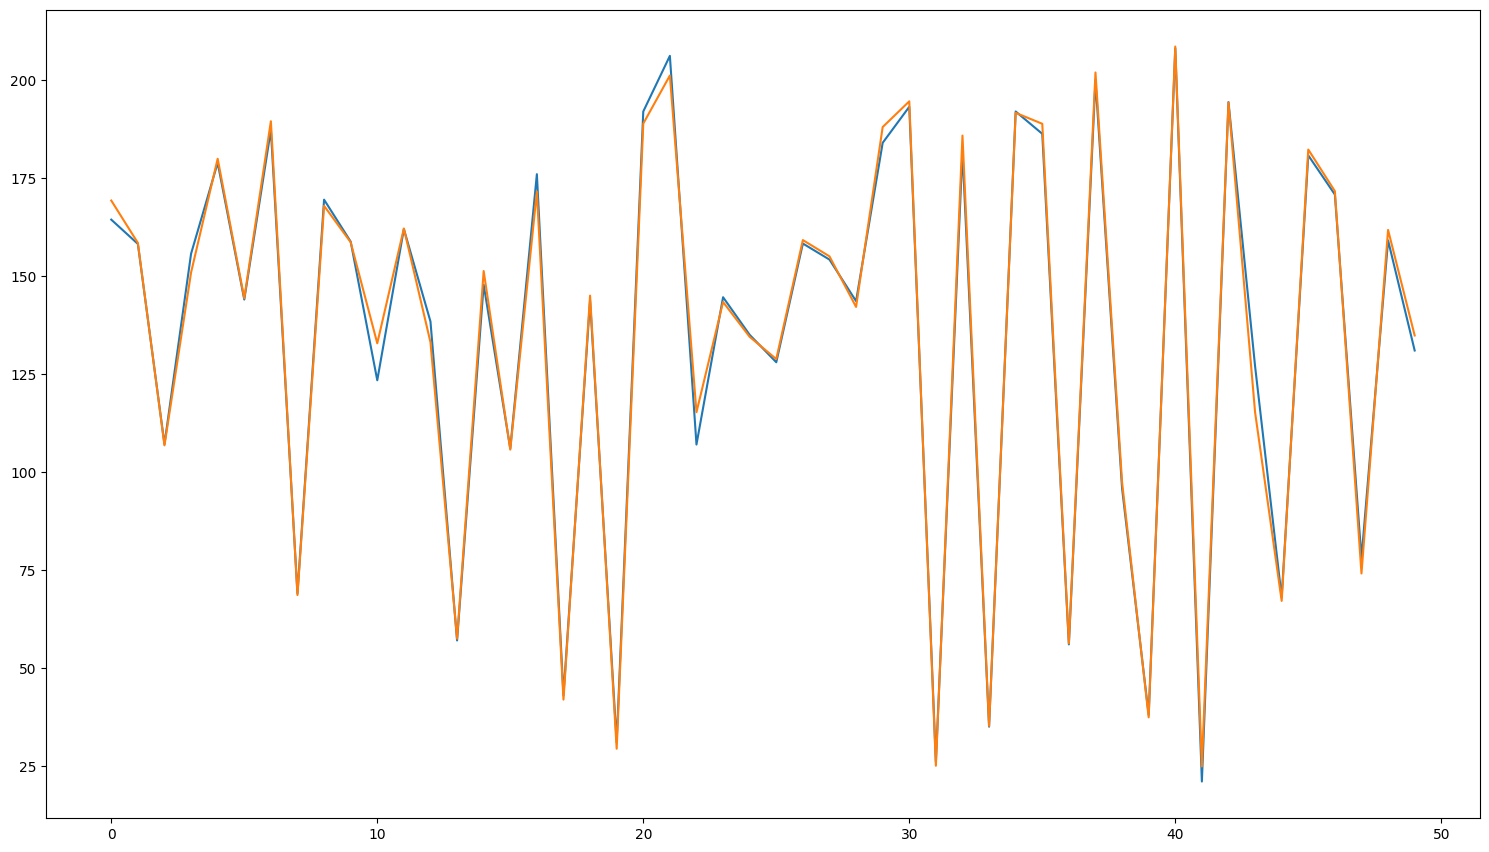

In [102]:
plt.plot(y_test[:50])
plt.plot(outputs[:50].detach())
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [106]:
torch.save(model.state_dict(), "lstm_1000_2_128")

In [107]:
from utils import get_data_pred

In [126]:
weather = get_data_pred('ACAvNTuEuFWcmwms')
weather = torch.tensor(weather.to_numpy(), dtype=torch.float32).resize()
weather = weather.reshape(-1, sequence_length, input_size)

C:\Morgan Stanley\quant-challenge\venv\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


RuntimeError: requested resize to  (1 elements in total), but the given tensor has a size of 17x888 (15096 elements). autograd's resize can only change the shape of a given tensor, while preserving the number of elements. 

In [ ]:
outputs = model(weather)

In [119]:
weather.shape

torch.Size([17, 888])